In [ ]:
%matplotlib inline


# SLIC AND GRAPH CUT


This example constructs a Region Adjacency Graph (RAG) and progressively merges
regions that are similar in color. Merging two adjacent regions produces
a new region with all the pixels from the merged regions. Regions are merged
until no highly similar region pairs remain.




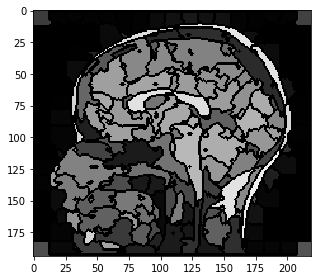

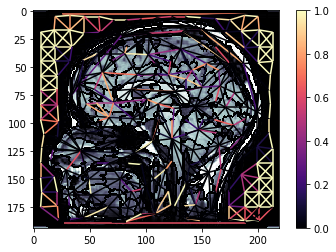

In [3]:
from skimage import data, io, segmentation, color
from skimage.future import graph
from skimage.color import rgb2gray
from skimage.filters import sobel
import numpy as np
import matplotlib.pyplot as plt
import cv2

img = io.imread("C:\\Users\\shyam\\Downloads\\brain_mri.jpg")
img=img[:,20:-20]
#labels = segmentation.slic(img, compactness=10, n_segments=400)
#labels = segmentation.quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
labels = segmentation.watershed(gradient, markers=250, compactness=0.001)
g = graph.rag_mean_color(img, labels, mode='similarity')

img_out = color.label2rgb(labels, img, kind='avg')
img_out = segmentation.mark_boundaries(img_out, labels, (0,0,0))
io.imshow(img_out)
io.show()
#x = plt.figure(1)
lg = graph.show_rag(labels, g, img)
plt.colorbar(lg)
plt.show()




[[  1   1   1 ...   1   1   1]
 [  1   1   1 ...   1   1   1]
 [  1   1   1 ...   1   1   1]
 ...
 [175 175 175 ... 175 175 175]
 [175 175 175 ... 175 175 175]
 [175 175 175 ... 175 175 175]]


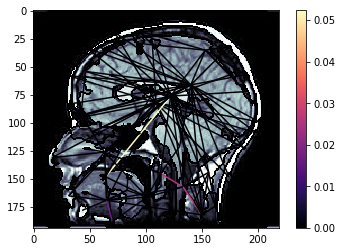

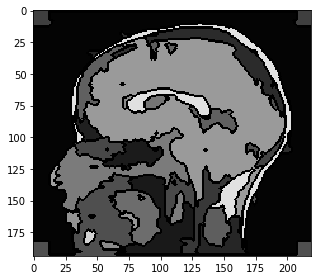

In [4]:
new_labels = graph.cut_normalized(labels, g)
print(new_labels)

new_g = graph.rag_mean_color(img, new_labels, mode='similarity')
lg = graph.show_rag(new_labels, new_g, img)
plt.colorbar(lg)
plt.show()

img_out = color.label2rgb(new_labels, img, kind='avg')
img_out = segmentation.mark_boundaries(img_out, new_labels, (0,0,0))
io.imshow(img_out)
io.show()

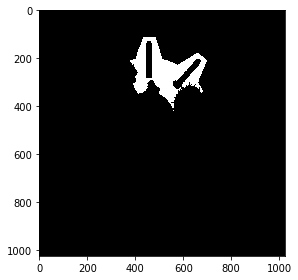

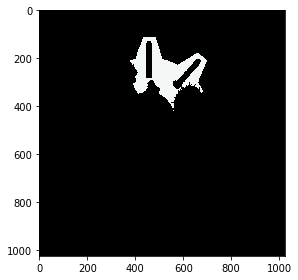

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [44]:
mask = np.zeros(img_out.shape[:2], dtype="uint8")
mask[new_labels == 48] = 255
io.imshow(mask)
io.show()
io.imshow(cv2.bitwise_and(img_out, img_out, mask=mask))
io.show()
print(mask)

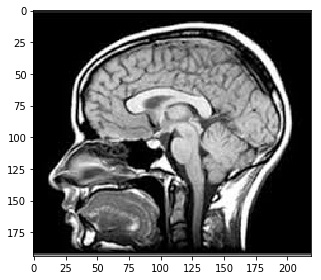

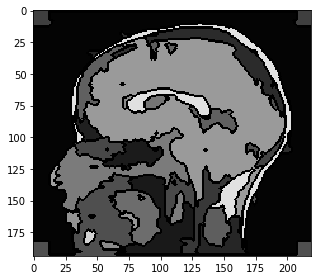

In [5]:
io.imshow(img)
io.show()
io.imshow(img_out)
io.show()

In [ ]:
#RAG
def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.node[dst]['mean color'] - graph.node[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.node[dst]['total color'] += graph.node[src]['total color']
    graph.node[dst]['pixel count'] += graph.node[src]['pixel count']
    graph.node[dst]['mean color'] = (graph.node[dst]['total color'] /
                                     graph.node[dst]['pixel count'])

new_labels = graph.merge_hierarchical(labels, g, thresh=35, rag_copy=False, in_place_merge=True,
                                      merge_func=merge_mean_color, weight_func=weight_mean_color)
print(new_labels)
img_out = color.label2rgb(new_labels, img, kind='avg')
img_out = segmentation.mark_boundaries(img_out, new_labels, (0,0,0))
io.imshow(img)
io.show()
io.imshow(img_out)
io.show()